### Cab-Driver Agent

In [6]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

### 1. Load the Time Matrix

In [7]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Check what the max, min and mean time values are. This will help us in defining the 'next_step' function in the Environment.

In [8]:
print(type(Time_matrix))
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())
print(Time_matrix.var())

<class 'numpy.ndarray'>
11.0
0.0
3.0542857142857143
7.93705306122449


#### Since the max time is 11 hours between any 2 points, the next state of the cab driver may increase at most by  1 day.

### 2. Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [9]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005 #for 15k
        #self.epsilon_decay = -0.00015 #for 20k
        self.epsilon_min = 0.00001
        
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        """
        Function that takes in the agent and constructs the network
        to train it
        @return model
        @params agent
        """
        input_shape = self.state_size
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, possible_actions_index, actions):
        """
        get action in a state according to an epsilon-greedy approach
        possible_actions_index, actions are the 'ride requests' that teh driver got.
        """        
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action_index, reward, next_state, done):
        """appends the new agent run output to replay buffer"""
        self.memory.append((state, action_index, reward, next_state, done))
        
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """ 
        Function to train the model on eacg step run.
        Picks the random memory events according to batch size and 
        runs it through the network to train it.
        """
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.model.predict(update_output)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        
    def save_test_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_test.append(q_value[0][2])

    def save(self, name):
        with open(name, 'wb') as file:  
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)

### 3. DQN block

for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    

    #Call the DQN agent
    
    
    while !terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        

In [13]:
episode_time = 24*30 #30 days before which car has to be recharged
n_episodes = 15000
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []

### 4. Run the episodes, build up replay buffer and train the model.
### Note:
#### The moment total episode time exceeds 720 (30 days), we ignore the most recent ride and do NOT save that experience in the replay memory
#### The init state is randomly picked from the state space for each episode

In [11]:
start_time = time.time()
score_tracked = []

for episode in range(n_episodes):

    done = False
    score = 0
    track_reward = False

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init


    total_time = 0  # Total time driver rode in this episode
    while not done:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete in stipu;ated time skip
            # it and move to next episode.
            done = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.pkl")
    
elapsed_time = time.time() - start_time
print(elapsed_time)




Saving Model 0
episode 9, reward -175.0, memory_length 1383, epsilon 0.9955001547284723 total_time 725.0
episode 19, reward 60.0, memory_length 2000, epsilon 0.9905350769930761 total_time 727.0
episode 29, reward -139.0, memory_length 2000, epsilon 0.9855947626861951 total_time 725.0
episode 39, reward -242.0, memory_length 2000, epsilon 0.9806790882997144 total_time 729.0
episode 49, reward -133.0, memory_length 2000, epsilon 0.9757879309415182 total_time 726.0
episode 59, reward -224.0, memory_length 2000, epsilon 0.9709211683324178 total_time 723.0
episode 69, reward -296.0, memory_length 2000, epsilon 0.9660786788030947 total_time 722.0
episode 79, reward -139.0, memory_length 2000, epsilon 0.9612603412910584 total_time 730.0
episode 89, reward -247.0, memory_length 2000, epsilon 0.9564660353376199 total_time 722.0
episode 99, reward 12.0, memory_length 2000, epsilon 0.9516956410848808 total_time 722.0
episode 109, reward 162.0, memory_length 2000, epsilon 0.9469490392727365 tota

episode 869, reward 640.0, memory_length 2000, epsilon 0.64758190444934 total_time 726.0
episode 879, reward 487.0, memory_length 2000, epsilon 0.6443520762264566 total_time 723.0
episode 889, reward 357.0, memory_length 2000, epsilon 0.6411383568390387 total_time 724.0
episode 899, reward 182.0, memory_length 2000, epsilon 0.6379406659439346 total_time 724.0
episode 909, reward 630.0, memory_length 2000, epsilon 0.6347589235987051 total_time 731.0
episode 919, reward 725.0, memory_length 2000, epsilon 0.631593050259626 total_time 727.0
episode 929, reward 367.0, memory_length 2000, epsilon 0.6284429667796988 total_time 721.0
episode 939, reward 269.0, memory_length 2000, epsilon 0.6253085944066726 total_time 724.0
episode 949, reward 276.0, memory_length 2000, epsilon 0.6221898547810748 total_time 722.0
episode 959, reward 432.0, memory_length 2000, epsilon 0.6190866699342522 total_time 725.0
episode 969, reward 871.0, memory_length 2000, epsilon 0.6159989622864221 total_time 723.0
ep

episode 1759, reward 943.0, memory_length 2000, epsilon 0.4149862050903786 total_time 725.0
episode 1769, reward 1113.0, memory_length 2000, epsilon 0.4129164527577405 total_time 727.0
episode 1779, reward 990.0, memory_length 2000, epsilon 0.41085702335792745 total_time 722.0
episode 1789, reward 672.0, memory_length 2000, epsilon 0.40880786540509717 total_time 727.0
episode 1799, reward 570.0, memory_length 2000, epsilon 0.4067689276701942 total_time 723.0
episode 1809, reward 1027.0, memory_length 2000, epsilon 0.40474015917966877 total_time 725.0
episode 1819, reward 924.0, memory_length 2000, epsilon 0.4027215092142031 total_time 725.0
episode 1829, reward 918.0, memory_length 2000, epsilon 0.4007129273074429 total_time 727.0
episode 1839, reward 901.0, memory_length 2000, epsilon 0.39871436324473586 total_time 726.0
episode 1849, reward 951.0, memory_length 2000, epsilon 0.3967257670618763 total_time 730.0
episode 1859, reward 918.0, memory_length 2000, epsilon 0.3947470890438561

episode 2639, reward 1198.0, memory_length 2000, epsilon 0.26726623032528185 total_time 726.0
episode 2649, reward 1260.0, memory_length 2000, epsilon 0.2659332344404412 total_time 730.0
episode 2659, reward 1356.0, memory_length 2000, epsilon 0.2646068869003122 total_time 723.0
episode 2669, reward 710.0, memory_length 2000, epsilon 0.2632871545461373 total_time 723.0
episode 2679, reward 843.0, memory_length 2000, epsilon 0.261974004384539 total_time 727.0
episode 2689, reward 792.0, memory_length 2000, epsilon 0.26066740358669477 total_time 731.0
episode 2699, reward 982.0, memory_length 2000, epsilon 0.25936731948751673 total_time 724.0
episode 2709, reward 1275.0, memory_length 2000, epsilon 0.2580737195848345 total_time 725.0
episode 2719, reward 1130.0, memory_length 2000, epsilon 0.25678657153858325 total_time 728.0
episode 2729, reward 1031.0, memory_length 2000, epsilon 0.2555058431699948 total_time 721.0
episode 2739, reward 1157.0, memory_length 2000, epsilon 0.254231502460

episode 3519, reward 990.0, memory_length 2000, epsilon 0.1721291864550771 total_time 722.0
episode 3529, reward 1362.0, memory_length 2000, epsilon 0.17127068855608577 total_time 723.0
episode 3539, reward 1312.0, memory_length 2000, epsilon 0.17041647243322863 total_time 721.0
episode 3549, reward 1028.0, memory_length 2000, epsilon 0.16956651673105824 total_time 721.0
episode 3559, reward 1117.0, memory_length 2000, epsilon 0.16872080020063768 total_time 724.0
episode 3569, reward 1278.0, memory_length 2000, epsilon 0.16787930169900972 total_time 723.0
episode 3579, reward 1476.0, memory_length 2000, epsilon 0.16704200018866794 total_time 723.0
episode 3589, reward 1224.0, memory_length 2000, epsilon 0.166208874737031 total_time 726.0
episode 3599, reward 1053.0, memory_length 2000, epsilon 0.1653799045159192 total_time 724.0
episode 3609, reward 1531.0, memory_length 2000, epsilon 0.16455506880103385 total_time 727.0
episode 3619, reward 1470.0, memory_length 2000, epsilon 0.163734

episode 4399, reward 1071.0, memory_length 2000, epsilon 0.11085746520848058 total_time 728.0
episode 4409, reward 2042.0, memory_length 2000, epsilon 0.11030456129410682 total_time 728.0
episode 4419, reward 1213.0, memory_length 2000, epsilon 0.10975441499951036 total_time 721.0
episode 4429, reward 1529.0, memory_length 2000, epsilon 0.10920701257100535 total_time 722.0
episode 4439, reward 1432.0, memory_length 2000, epsilon 0.10866234032350246 total_time 724.0
episode 4449, reward 1521.0, memory_length 2000, epsilon 0.10812038464016717 total_time 726.0
episode 4459, reward 1891.0, memory_length 2000, epsilon 0.10758113197207911 total_time 722.0
episode 4469, reward 1762.0, memory_length 2000, epsilon 0.10704456883789358 total_time 726.0
episode 4479, reward 1362.0, memory_length 2000, epsilon 0.10651068182350425 total_time 724.0
episode 4489, reward 1377.0, memory_length 2000, epsilon 0.10597945758170793 total_time 728.0
episode 4499, reward 1986.0, memory_length 2000, epsilon 0.1

episode 5279, reward 704.0, memory_length 2000, epsilon 0.0713962451432187 total_time 731.0
episode 5289, reward 1717.0, memory_length 2000, epsilon 0.07104015488500255 total_time 725.0
episode 5299, reward 1436.0, memory_length 2000, epsilon 0.07068584063435851 total_time 722.0
episode 5309, reward 1507.0, memory_length 2000, epsilon 0.07033329353341192 total_time 721.0
episode 5319, reward 1876.0, memory_length 2000, epsilon 0.06998250476846683 total_time 721.0
episode 5329, reward 1700.0, memory_length 2000, epsilon 0.0696334655697859 total_time 724.0
episode 5339, reward 1503.0, memory_length 2000, epsilon 0.06928616721137094 total_time 722.0
episode 5349, reward 1379.0, memory_length 2000, epsilon 0.06894060101074494 total_time 724.0
episode 5359, reward 1242.0, memory_length 2000, epsilon 0.06859675832873488 total_time 727.0
episode 5369, reward 1760.0, memory_length 2000, epsilon 0.06825463056925578 total_time 721.0
episode 5379, reward 1387.0, memory_length 2000, epsilon 0.0679

episode 6149, reward 1827.0, memory_length 2000, epsilon 0.046212266843247196 total_time 725.0
episode 6159, reward 1899.0, memory_length 2000, epsilon 0.04598178220081319 total_time 721.0
episode 6169, reward 1480.0, memory_length 2000, epsilon 0.04575244710532907 total_time 722.0
episode 6179, reward 1731.0, memory_length 2000, epsilon 0.045524255823405545 total_time 723.0
episode 6189, reward 1450.0, memory_length 2000, epsilon 0.04529720265024866 total_time 724.0
episode 6199, reward 1766.0, memory_length 2000, epsilon 0.045071281909517265 total_time 722.0
episode 6209, reward 1638.0, memory_length 2000, epsilon 0.04484648795318105 total_time 729.0
episode 6219, reward 1787.0, memory_length 2000, epsilon 0.04462281516137944 total_time 724.0
episode 6229, reward 1353.0, memory_length 2000, epsilon 0.044400257942280974 total_time 723.0
episode 6239, reward 1702.0, memory_length 2000, epsilon 0.04417881073194358 total_time 723.0
episode 6249, reward 2039.0, memory_length 2000, epsilon

episode 7019, reward 1955.0, memory_length 2000, epsilon 0.029911567513215692 total_time 724.0
episode 7029, reward 1639.0, memory_length 2000, epsilon 0.029762382947864045 total_time 727.0
episode 7039, reward 1665.0, memory_length 2000, epsilon 0.029613942443636205 total_time 725.0
episode 7049, reward 491.0, memory_length 2000, epsilon 0.029466242289511866 total_time 724.0
episode 7059, reward 1928.0, memory_length 2000, epsilon 0.029319278792979464 total_time 724.0
episode 7069, reward 1677.0, memory_length 2000, epsilon 0.029173048279943936 total_time 724.0
episode 7079, reward 1455.0, memory_length 2000, epsilon 0.029027547094634832 total_time 723.0
episode 7089, reward 1952.0, memory_length 2000, epsilon 0.02888277159951494 total_time 721.0
episode 7099, reward 1761.0, memory_length 2000, epsilon 0.028738718175189356 total_time 721.0
episode 7109, reward 1592.0, memory_length 2000, epsilon 0.028595383220314963 total_time 724.0
episode 7119, reward 1527.0, memory_length 2000, eps

episode 7889, reward 1683.0, memory_length 2000, epsilon 0.01936070078822371 total_time 721.0
episode 7899, reward 1788.0, memory_length 2000, epsilon 0.019264138890198193 total_time 727.0
episode 7909, reward 1910.0, memory_length 2000, epsilon 0.019168058596648274 total_time 727.0
episode 7919, reward 1850.0, memory_length 2000, epsilon 0.0190724575055616 total_time 730.0
episode 7929, reward 1598.0, memory_length 2000, epsilon 0.018977333226905934 total_time 727.0
episode 7939, reward 1797.0, memory_length 2000, epsilon 0.018882683382569338 total_time 722.0
episode 7949, reward 1872.0, memory_length 2000, epsilon 0.018788505606300788 total_time 727.0
episode 7959, reward 1051.0, memory_length 2000, epsilon 0.01869479754365095 total_time 721.0
episode 7969, reward 1671.0, memory_length 2000, epsilon 0.0186015568519134 total_time 726.0
episode 7979, reward 1409.0, memory_length 2000, epsilon 0.018508781200065983 total_time 730.0
episode 7989, reward 1733.0, memory_length 2000, epsilon

episode 8759, reward 1878.0, memory_length 2000, epsilon 0.012531497550087062 total_time 726.0
episode 8769, reward 1800.0, memory_length 2000, epsilon 0.012468996445309154 total_time 721.0
episode 8779, reward 1382.0, memory_length 2000, epsilon 0.012406807066091805 total_time 725.0
episode 8789, reward 1756.0, memory_length 2000, epsilon 0.012344927857697297 total_time 729.0
episode 8799, reward 1845.0, memory_length 2000, epsilon 0.012283357273142198 total_time 730.0
episode 8809, reward 1989.0, memory_length 2000, epsilon 0.012222093773158674 total_time 734.0
episode 8819, reward 1500.0, memory_length 2000, epsilon 0.012161135826156058 total_time 723.0
episode 8829, reward 1936.0, memory_length 2000, epsilon 0.01210048190818249 total_time 728.0
episode 8839, reward 1967.0, memory_length 2000, epsilon 0.01204013050288686 total_time 722.0
episode 8849, reward 1869.0, memory_length 2000, epsilon 0.011980080101480892 total_time 725.0
episode 8859, reward 1713.0, memory_length 2000, eps

episode 9629, reward 1633.0, memory_length 2000, epsilon 0.00811119558974631 total_time 729.0
episode 9639, reward 1544.0, memory_length 2000, epsilon 0.008070740832970229 total_time 722.0
episode 9649, reward 1177.0, memory_length 2000, epsilon 0.008030487845135315 total_time 721.0
episode 9659, reward 1206.0, memory_length 2000, epsilon 0.007990435619914792 total_time 727.0
episode 9669, reward 1763.0, memory_length 2000, epsilon 0.007950583156000935 total_time 726.0
episode 9679, reward 1530.0, memory_length 2000, epsilon 0.007910929457080072 total_time 722.0
episode 9689, reward 1728.0, memory_length 2000, epsilon 0.007871473531807663 total_time 726.0
episode 9699, reward 1725.0, memory_length 2000, epsilon 0.007832214393783524 total_time 727.0
episode 9709, reward 1944.0, memory_length 2000, epsilon 0.007793151061527156 total_time 722.0
episode 9719, reward 1841.0, memory_length 2000, epsilon 0.00775428255845322 total_time 727.0
episode 9729, reward 1225.0, memory_length 2000, eps

episode 10489, reward 1801.0, memory_length 2000, epsilon 0.005276406500209628 total_time 721.0
episode 10499, reward 1774.0, memory_length 2000, epsilon 0.005250090313001966 total_time 725.0
episode 10509, reward 1866.0, memory_length 2000, epsilon 0.005223905378325572 total_time 726.0
episode 10519, reward 1245.0, memory_length 2000, epsilon 0.005197851041555715 total_time 725.0
episode 10529, reward 1158.0, memory_length 2000, epsilon 0.005171926651332619 total_time 724.0
episode 10539, reward 1175.0, memory_length 2000, epsilon 0.005146131559545177 total_time 721.0
episode 10549, reward 1906.0, memory_length 2000, epsilon 0.005120465121314752 total_time 724.0
episode 10559, reward 2133.0, memory_length 2000, epsilon 0.005094926694979046 total_time 728.0
episode 10569, reward 1864.0, memory_length 2000, epsilon 0.00506951564207608 total_time 727.0
episode 10579, reward 309.0, memory_length 2000, epsilon 0.005044231327328204 total_time 726.0
episode 10589, reward 1883.0, memory_lengt

episode 11349, reward 1715.0, memory_length 2000, epsilon 0.003432350415843589 total_time 723.0
episode 11359, reward 1505.0, memory_length 2000, epsilon 0.003415231496726564 total_time 726.0
episode 11369, reward 1784.0, memory_length 2000, epsilon 0.0033981979585748336 total_time 724.0
episode 11379, reward 1466.0, memory_length 2000, epsilon 0.0033812493755490574 total_time 726.0
episode 11389, reward 1872.0, memory_length 2000, epsilon 0.003364385323933774 total_time 733.0
episode 11399, reward 1496.0, memory_length 2000, epsilon 0.0033476053821268207 total_time 726.0
episode 11409, reward 1790.0, memory_length 2000, epsilon 0.0033309091306287742 total_time 722.0
episode 11419, reward 2079.0, memory_length 2000, epsilon 0.0033142961520324795 total_time 721.0
episode 11429, reward 1271.0, memory_length 2000, epsilon 0.0032977660310126045 total_time 728.0
episode 11439, reward 1837.0, memory_length 2000, epsilon 0.0032813183543152643 total_time 721.0
episode 11449, reward 1563.0, mem

episode 12199, reward 1818.0, memory_length 2000, epsilon 0.0022439669938564056 total_time 724.0
episode 12209, reward 1869.0, memory_length 2000, epsilon 0.0022327751617836128 total_time 721.0
episode 12219, reward 2050.0, memory_length 2000, epsilon 0.002221639149206155 total_time 723.0
episode 12229, reward 1755.0, memory_length 2000, epsilon 0.002210558677723136 total_time 730.0
episode 12239, reward 1887.0, memory_length 2000, epsilon 0.0021995334703221957 total_time 723.0
episode 12249, reward 1845.0, memory_length 2000, epsilon 0.002188563251372572 total_time 721.0
episode 12259, reward 1740.0, memory_length 2000, epsilon 0.002177647746618221 total_time 722.0
episode 12269, reward 1658.0, memory_length 2000, epsilon 0.0021667866831709542 total_time 721.0
episode 12279, reward 1658.0, memory_length 2000, epsilon 0.00215597978950362 total_time 722.0
episode 12289, reward 1674.0, memory_length 2000, epsilon 0.0021452267954433146 total_time 721.0
episode 12299, reward 1580.0, memory

episode 13049, reward 1788.0, memory_length 2000, epsilon 0.0014670378194119717 total_time 722.0
episode 13059, reward 1919.0, memory_length 2000, epsilon 0.0014597209377625313 total_time 723.0
episode 13069, reward 1926.0, memory_length 2000, epsilon 0.0014524405492125636 total_time 721.0
episode 13079, reward 1810.0, memory_length 2000, epsilon 0.0014451964717519742 total_time 723.0
episode 13089, reward 1747.0, memory_length 2000, epsilon 0.0014379885242784493 total_time 721.0
episode 13099, reward 1819.0, memory_length 2000, epsilon 0.0014308165265929267 total_time 725.0
episode 13109, reward 1927.0, memory_length 2000, epsilon 0.0014236802993950906 total_time 724.0
episode 13119, reward 1773.0, memory_length 2000, epsilon 0.0014165796642788893 total_time 721.0
episode 13129, reward 1778.0, memory_length 2000, epsilon 0.0014095144437280755 total_time 727.0
episode 13139, reward 1877.0, memory_length 2000, epsilon 0.0014024844611117656 total_time 727.0
episode 13149, reward 1909.0, 

episode 13899, reward 1895.0, memory_length 2000, epsilon 0.0009591049999743237 total_time 722.0
episode 13909, reward 1815.0, memory_length 2000, epsilon 0.0009543214438305494 total_time 724.0
episode 13919, reward 1598.0, memory_length 2000, epsilon 0.0009495617457725752 total_time 722.0
episode 13929, reward 1826.0, memory_length 2000, epsilon 0.0009448257868077017 total_time 724.0
episode 13939, reward 1680.0, memory_length 2000, epsilon 0.0009401134485367081 total_time 722.0
episode 13949, reward 1342.0, memory_length 2000, epsilon 0.0009354246131508923 total_time 723.0
episode 13959, reward 1756.0, memory_length 2000, epsilon 0.0009307591634291251 total_time 723.0
episode 13969, reward 1742.0, memory_length 2000, epsilon 0.0009261169827349209 total_time 724.0
episode 13979, reward 1715.0, memory_length 2000, epsilon 0.0009214979550135194 total_time 723.0
episode 13989, reward 1959.0, memory_length 2000, epsilon 0.0009169019647889888 total_time 725.0
episode 13999, reward 1811.0, 

episode 14749, reward 1647.0, memory_length 2000, epsilon 0.000627033869750176 total_time 731.0
episode 14759, reward 1477.0, memory_length 2000, epsilon 0.0006239065252779041 total_time 731.0
episode 14769, reward 1648.0, memory_length 2000, epsilon 0.0006207947785012593 total_time 721.0
episode 14779, reward 1717.0, memory_length 2000, epsilon 0.0006176985516264101 total_time 721.0
episode 14789, reward 1785.0, memory_length 2000, epsilon 0.0006146177672475235 total_time 721.0
episode 14799, reward 1735.0, memory_length 2000, epsilon 0.0006115523483448293 total_time 723.0
episode 14809, reward 1657.0, memory_length 2000, epsilon 0.0006085022182826951 total_time 731.0
episode 14819, reward 1242.0, memory_length 2000, epsilon 0.0006054673008077113 total_time 726.0
episode 14829, reward 2244.0, memory_length 2000, epsilon 0.0006024475200467823 total_time 721.0
episode 14839, reward 1688.0, memory_length 2000, epsilon 0.0005994428005052322 total_time 723.0
episode 14849, reward 1191.0, m

### The 'total_time' above includes the 'last ride' time also in each episode. Although it exceeds 24*30 = 720, our code drops the last ride from the replay buffer. So the total ride time per episode is limited to < 720

In [22]:
agent.save(name="model_weights.pkl")

### Tracking Convergence

In [23]:
agent.states_tracked

[]

In [24]:
state_tracked_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

### 5. Plot the Q-Value convergence for state action pairs

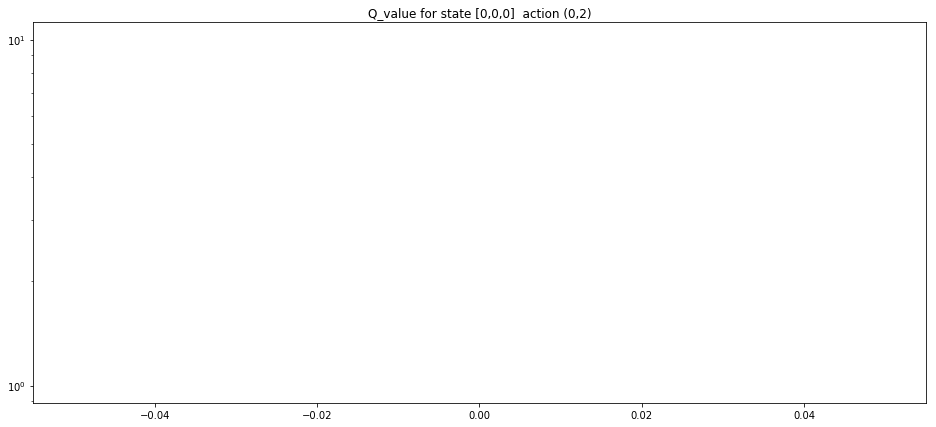

In [25]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

#### We are using log scale because the initial q_values are way to high compared to the steady state value (around 600)

### 6. Track rewards per episode.

In [26]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

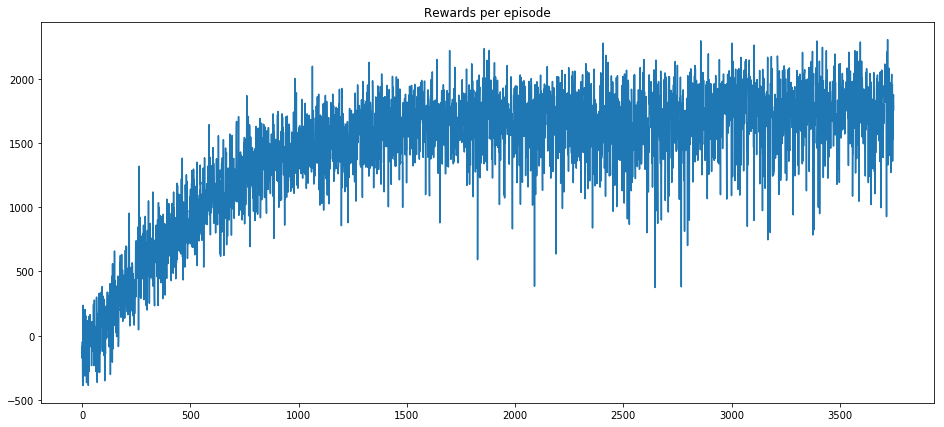

In [27]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

### We can see from the above plot that the rewards converge at around 1500. Since the initial state is picked to be random for each episode, some initial states may be less rewarding than others inherently regardless of the model quality.

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [28]:
import numpy as np
time = np.arange(0,15000)
epsilon = []
for i in range(0,15000):
    epsilon.append((1 - 0.00001) * np.exp(-0.0005 * i))

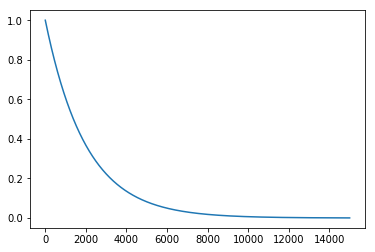

In [29]:
import matplotlib.pyplot as plt
plt.plot(time, epsilon)
plt.show()